In [1]:
from dem.energies.tblite_energy import TBLiteEnergy
import numpy as np
import pickle
import torch 
from dem.energies.base_energy_function import BaseEnergyFunction
from dem.energies.lennardjones_energy import LennardJonesEnergy 
from dem.models.components.clipper import Clipper
from dem.models.components.noise_schedules import BaseNoiseSchedule, GeometricNoiseSchedule
from dem.models.components.score_estimator import get_logreward_noised_samples

In [5]:
energy_function = TBLiteEnergy(dimensionality = 3*69, n_particles = 69, is_molecule=True, data_path ='/home/mila/l/lena-nehale.ezzine/Amgen/DEM/data/TIfV_val.npy',   data_path_train='/home/mila/l/lena-nehale.ezzine/Amgen/DEM/data/TIfV_train.npy', data_path_val='/home/mila/l/lena-nehale.ezzine/Amgen/DEM/data/TIfV_val.npy', T=0.1)

In [6]:
coords = torch.tensor(np.load('/home/mila/l/lena-nehale.ezzine/Amgen/DEM/data/TIfV_val.npy'), dtype=torch.float32)
atom_ids = pickle.load(open('/home/mila/l/lena-nehale.ezzine/Amgen/DEM/data/atom_ids.pkl', 'rb'))

In [9]:
energy_function(torch.rand(69,3))

------------------------------------------------------------
  cycle        total energy    energy error   density error
------------------------------------------------------------
      1      11696.82296596   6.3654270E+03   2.1577181E+00
      2      11694.84449147  -1.9784745E+00   1.2755375E+00
      3      11693.83864785  -1.0058436E+00   9.1754637E-02
      4      11693.75435246  -8.4295385E-02   5.3377027E-02
      5      11693.85161613   9.7263673E-02   3.9444354E-02
      6      11693.68669610  -1.6492004E-01   2.1767680E-02
      7      11693.65849108  -2.8205019E-02   1.5797328E-02
      8      11693.65527664  -3.2144329E-03   1.3629944E-02
------------------------------------------------------------

 total:                                   1.623 sec
log rew -116936.5527664498


tensor(-116936.5547)

In [4]:
energy_function.interatomic_dist(coords).shape

torch.Size([283, 2346])

In [7]:
grads = energy_function(coords[:2].unsqueeze(0).unsqueeze(0))
grads.shape

------------------------------------------------------------
  cycle        total energy    energy error   density error
------------------------------------------------------------
      1     -101.2379595160  -1.0254221E+02   1.6242103E-01
      2     -101.8354361927  -5.9747668E-01   6.4933516E-02
      3     -101.8713076978  -3.5871505E-02   3.7344083E-02
      4     -101.8826051226  -1.1297425E-02   1.0278015E-02
      5     -101.8844306159  -1.8254933E-03   4.4548929E-03
------------------------------------------------------------

 total:                                   2.213 sec
log rew 101.88443061590056
------------------------------------------------------------
  cycle        total energy    energy error   density error
------------------------------------------------------------
      1     -101.2374035518  -1.0254175E+02   1.6240706E-01
      2     -101.8352837297  -5.9788018E-01   6.4946729E-02
      3     -101.8712113826  -3.5927653E-02   3.7351489E-02
      4     -10

torch.Size([1, 1, 2])

In [10]:
e0 = energy_function(coords[0])
grads = energy_function.get_gradient(coords[0])
e1 = energy_function(coords[0] + 1e0 * grads)
e0, e1

------------------------------------------------------------
  cycle        total energy    energy error   density error
------------------------------------------------------------
      1     -101.2379595160  -1.0254221E+02   1.6242103E-01
      2     -101.8354361927  -5.9747668E-01   6.4933516E-02
      3     -101.8713076978  -3.5871505E-02   3.7344083E-02
      4     -101.8826051226  -1.1297425E-02   1.0278015E-02
      5     -101.8844306159  -1.8254933E-03   4.4548929E-03
      6     -101.8848423873  -4.1177144E-04   1.6148188E-03
      7     -101.8848654878  -2.3100480E-05   6.8722718E-04
      8     -101.8848755082  -1.0020362E-05   3.6223155E-04
      9     -101.8848774218  -1.9136250E-06   8.8704758E-05
------------------------------------------------------------

 total:                                   2.065 sec
tensor([101.8849]) torch.Size([1])
------------------------------------------------------------
  cycle        total energy    energy error   density error
--------

(tensor(101.8849), tensor(101.8843))

In [5]:

energy_function = LennardJonesEnergy(dimensionality = 39,
        n_particles = 13,
        data_path = 'data/test_split_LJ13-1000.npy',
        data_path_train = "data/train_split_LJ13-1000.npy",
        data_path_val =  "data/test_split_LJ13-1000.npy")

noise_schedule = GeometricNoiseSchedule(sigma_min=0.01, sigma_max=2)
num_mc_samples = 10
clipper = Clipper(should_clip_scores=True,
                should_clip_log_rewards= False,
                max_score_norm= 20,
                min_log_reward= None)

In [6]:
bs = 5
t = torch.Tensor([bs])
x = torch.rand(bs,39)


In [72]:
samples, log_rewards = get_logreward_noised_samples(t, x, energy_function, noise_schedule, num_mc_samples, clipper)

In [73]:
samples.shape, log_rewards.shape

(torch.Size([10, 5, 39]), torch.Size([10, 1, 5]))

In [27]:
weights = torch.softmax(log_rewards, dim=-1).unsqueeze(-1)

In [32]:
log_rewards, torch.exp(log_rewards)/torch.sum(torch.exp(log_rewards))

(tensor([[-7.0318e+01],
         [-6.5862e+01],
         [-3.2641e+04],
         [-3.0963e+02],
         [-9.7251e+01],
         [-6.8172e+01],
         [-6.4121e+01],
         [-2.0791e+07],
         [-4.7405e+05],
         [-7.2687e+01]]),
 tensor([[1.7046e-03],
         [1.4672e-01],
         [0.0000e+00],
         [0.0000e+00],
         [3.4255e-15],
         [1.4573e-02],
         [8.3685e-01],
         [0.0000e+00],
         [0.0000e+00],
         [1.5948e-04]]))

In [35]:
torch.softmax(log_rewards, dim=0)

tensor([[1.7046e-03],
        [1.4672e-01],
        [0.0000e+00],
        [0.0000e+00],
        [3.4248e-15],
        [1.4573e-02],
        [8.3685e-01],
        [0.0000e+00],
        [0.0000e+00],
        [1.5948e-04]])

In [3]:
def f(x):
    return x

gradf = torch.func.grad(f)

In [6]:
gradf(torch.tensor(1.0))

tensor(1.)

###  Make datasets for cyclic peptides idem

In [1]:
import numpy as np

data = np.load('data/test_split_LJ13-1000.npy')
data.shape

(10000, 39)

In [4]:
from Bio import PDB
import numpy as np
import periodictable

def get_atomicnumber(max_Z = 50):
    '''Maps the atomic number to the atom elements in the periodic table.'''
    atom2atomicnumber = {}
    atomicnumber2atom = {}
    for atomicnumber in range(max_Z):
        element = periodictable.elements[atomicnumber + 1] 
        atom2atomicnumber[element.symbol] = atomicnumber + 1
        atomicnumber2atom[atomicnumber + 1] = element.symbol
    return atom2atomicnumber, atomicnumber2atom


def extract_column_from_pdb(pdb_path, start, end):
    column_data = []
    with open(pdb_path, 'r') as pdb_file:
        for line in pdb_file:
            if line.startswith('ENDMDL'):
                break
            if line.startswith('ATOM'):
                column_value = line[start:end].strip() 
                column_data.append(column_value)
    return column_data

def get_coord(model):
    '''Extracts the coordinates of the atoms in the model.'''
    coords = []
    for chain in model:
        for residue in chain:
            for atom in residue:
                x,y,z = atom.get_coord()
                coords.append([x,y,z])
    return np.array(coords).flatten()


def get_models_atoms(pdb_path ):
    '''Extracts the models and atom ids from the pdb file.'''
    atom2atomicnumber, _ = get_atomicnumber()
    parser = PDB.PDBParser()
    io = PDB.PDBIO()
    struct = parser.get_structure('structure_id',f'{pdb_path}')
    atom_names = []
    models = list(struct.get_models())
    atom_names = extract_column_from_pdb(f'{pdb_path}', 77, 78)
    atom_ids = np.array([atom2atomicnumber[x] for x in atom_names ])
    return models, atom_ids

def get_coords(pdb_path):
    models, atom_ids = get_models_atoms(pdb_path)
    coords = []
    for model in models:
        coords.append(get_coord(model))
    return np.array(coords)


In [5]:
pdb_path = '/home/mila/l/lena-nehale.ezzine/Amgen/DEM/data/T.I.f.V.pdb'
coords = get_coords(pdb_path)
coords.shape

(283, 207)

In [6]:
coords_train, coords_val = np.array([]), coords
np.save('/home/mila/l/lena-nehale.ezzine/Amgen/DEM/data/TIfV_train.npy', coords_train)
np.save('/home/mila/l/lena-nehale.ezzine/Amgen/DEM/data/TIfV_val.npy', coords_val)


# TorchANI

In [1]:
import numpy as np
import pickle
import torch
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')
coords = torch.tensor(np.load('/home/mila/l/lena-nehale.ezzine/Amgen/DEM_fork/data/TIfV_val.npy'), dtype=torch.float32).to(device).view(-1,69,3)
coords.requires_grad = True
atom_ids = torch.Tensor(pickle.load(open('/home/mila/l/lena-nehale.ezzine/Amgen/DEM_fork/data/atom_ids.pkl', 'rb'))).to(device).long().unsqueeze(0)

In [5]:

import torchani

model = torchani.models.ANI2x(periodic_table_index=True).to(device)

/home/mila/l/lena-nehale.ezzine/Amgen/DEM_fork/y/envs/dem/lib/python3.10/site-packages/torchani/resources/


In [7]:
model((atom_ids.repeat(10,1), coords[:10]))

SpeciesEnergies(species=tensor([[1, 1, 1, 1, 1, 2, 1, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 3, 1, 1, 1,
         1, 1, 1, 1, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 3, 1, 1, 1, 1, 2, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 1, 3, 1, 1, 1, 3, 2, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 2, 1, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 3, 1, 1, 1,
         1, 1, 1, 1, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 3, 1, 1, 1, 1, 2, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 1, 3, 1, 1, 1, 3, 2, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 2, 1, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 3, 1, 1, 1,
         1, 1, 1, 1, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 3, 1, 1, 1, 1, 2, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 1, 3, 1, 1, 1, 3, 2, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 2, 1, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 3, 1, 1, 1,
         1, 1, 1, 1, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 3, 1, 1, 1, 1, 2, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 1, 3, 1, 1, 1, 3, 2, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 2, 1, 3, 0, 

In [2]:


abs_coords = torch.abs(coords)
#abs_coords.max(), abs_coords.min(), abs_coords.mean(), abs_coords.std()
coords.max(), coords.min(), coords.mean(), coords.std()


(tensor(7.0580, device='cuda:0', grad_fn=<MaxBackward1>),
 tensor(-7.8810, device='cuda:0', grad_fn=<MinBackward1>),
 tensor(0.0212, device='cuda:0', grad_fn=<MeanBackward0>),
 tensor(2.5340, device='cuda:0', grad_fn=<StdBackward0>))

Let's compare the torchANI-energy distribution for conformations optimized using GFN2xtb, vs random conformations. If they are the same, torchANI is not a good proxy for GFN2xtb.

In [3]:
def get_logrew(coords):
    return - model((atom_ids.repeat(len(coords), 1), coords)).energies

test_data_logrews =  get_logrew(coords)
random_data_logrews = get_logrew(3*torch.rand_like(coords).requires_grad_(True))

i=0
derivative = torch.stack([torch.autograd.grad( test_data_logrews[i] , coords, retain_graph=True)[0][i] for i in range(len(coords))])
derivative.shape  

/tmp/ipykernel_767406/1542577825.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([x for x in dict_data.keys() ])


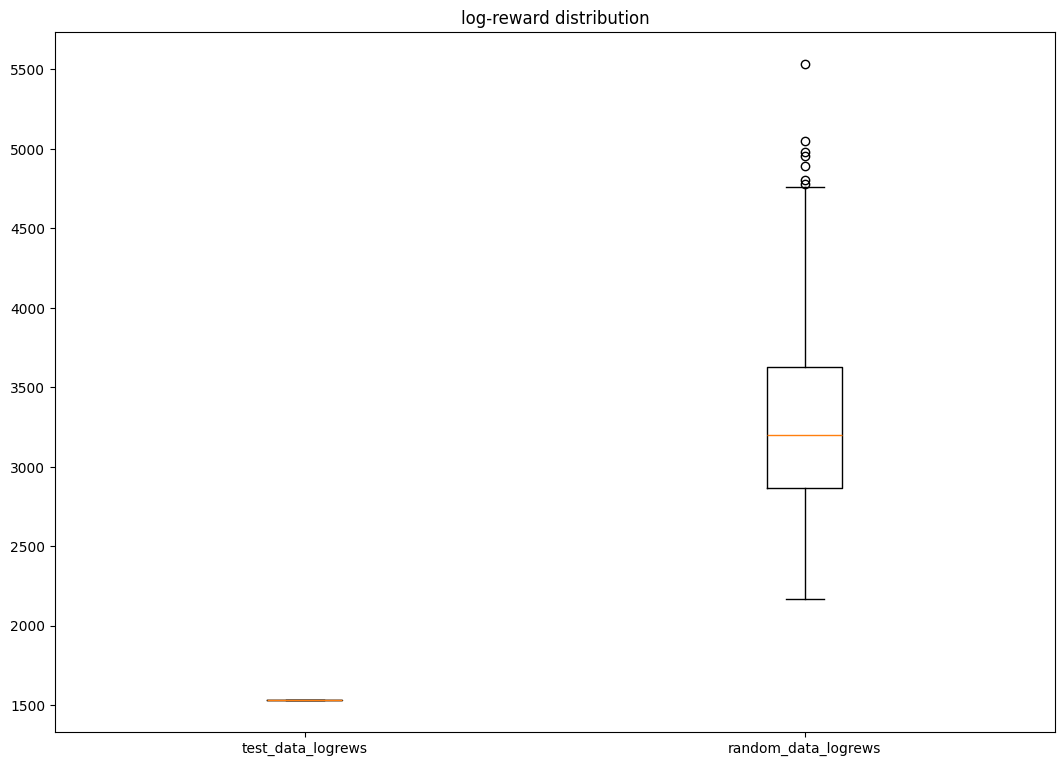

In [4]:
import matplotlib.pyplot as plt

#plt.hist(test_data_energies.detach().cpu(), bins = 50)
#plt.hist(random_data_energies.detach().cpu(), bins = 50)

dict_data = {'test_data_logrews': test_data_logrews.detach().cpu() , 'random_data_logrews':  random_data_logrews.detach().cpu()}
data = [x for x in dict_data.values()]
 
fig = plt.figure(figsize =(10, 7)) 
ax = fig.add_axes([0, 0, 1, 1])
ax.set_xticklabels([x for x in dict_data.keys() ])
ax.set_title('log-reward distribution')
# Creating plot
bp = ax.boxplot(data)

# show plot
plt.show()


In [2]:
from dem.energies.torchani_energy import *
energy_function = TorchaniEnergy(dimensionality = 3*69, n_particles = 69, is_molecule=True, data_path ='/home/mila/l/lena-nehale.ezzine/Amgen/DEM_fork/data/TIfV_val.npy',   data_path_train='/home/mila/l/lena-nehale.ezzine/Amgen/DEM_fork/data/TIfV_train.npy', data_path_val='/home/mila/l/lena-nehale.ezzine/Amgen/DEM_fork/data/TIfV_val.npy', T=0.1, device= device)

/home/mila/l/lena-nehale.ezzine/Amgen/DEM_fork/y/envs/dem/lib/python3.10/site-packages/torchani/aev.py:16: UserWarning: cuaev not installed
  warnings.warn("cuaev not installed")
/home/mila/l/lena-nehale.ezzine/Amgen/DEM_fork/y/envs/dem/lib/python3.10/site-packages/torchani/__init__.py:55: UserWarning: Dependency not satisfied, torchani.ase will not be available
  warnings.warn("Dependency not satisfied, torchani.ase will not be available")


/home/mila/l/lena-nehale.ezzine/Amgen/DEM_fork/y/envs/dem/lib/python3.10/site-packages/torchani/resources/


In [3]:
energy_function(torch.rand_like(coords[:10]))

tensor([87340.1968, 82241.2984, 84152.4234, 85947.9390, 87001.6421, 86114.8140,
        84370.3921, 85882.9859, 85966.4859, 84409.5249], dtype=torch.float64,
       grad_fn=<ViewBackward0>)

In [5]:
energy_function(coords[:10])

tensor([1531.1035, 1531.1037, 1531.1033, 1531.1062, 1531.1061, 1531.1061,
        1531.1038, 1531.1041, 1531.1065, 1531.1064], device='cuda:0',
       dtype=torch.float64, grad_fn=<ViewBackward0>)

In [6]:
grads = energy_function.score(coords)
grads.shape

cuda tensor([[[ 0.6320,  5.4290, -1.8180],
         [ 0.2210,  4.4380, -0.7350],
         [-0.3180,  3.1200, -1.3060],
         ...,
         [ 4.9660,  0.5260,  2.8970],
         [ 3.7010,  1.2940, -0.3680],
         [ 1.8830, -1.3830,  1.7850]],

        [[ 0.7240,  5.4200, -1.8250],
         [ 0.2820,  4.4520, -0.7330],
         [-0.2860,  3.1420, -1.2940],
         ...,
         [ 5.0740, -0.0450,  1.1940],
         [ 3.7180,  1.2870, -0.3800],
         [ 1.8930, -1.3780,  1.7820]],

        [[ 0.5120,  5.5040, -1.7360],
         [ 0.1740,  4.4780, -0.6590],
         [-0.3650,  3.1630, -1.2330],
         ...,
         [ 5.0790,  0.5730,  2.7570],
         [ 3.6930,  1.2610, -0.4740],
         [ 1.9320, -1.3500,  1.7980]],

        ...,

        [[ 0.8220,  5.0030, -0.2270],
         [-0.6420,  4.5970, -0.3570],
         [-0.8700,  3.1870, -0.9150],
         ...,
         [ 5.9950,  1.7560, -0.2160],
         [ 4.1240,  2.3290, -1.5260],
         [ 2.1020, -0.2220, -0.5840]],

     

torch.Size([283, 69, 3])

In [9]:
torch.cuda.empty_cache()

In [10]:
from pynvml import *
nvmlInit()
h = nvmlDeviceGetHandleByIndex(0)
info = nvmlDeviceGetMemoryInfo(h)
print(f'total    : {info.total}')
print(f'free     : {info.free}')
print(f'used     : {info.used}')

total    : 34359738368
free     : 7981105152
used     : 26378633216


In [19]:
print(torch.abs(grads.to(device) -  derivative[:100]).max() ),  
print('derivative mean', torch.abs(derivative).mean() )
print('grads mean', torch.abs(grads).mean() )

tensor(4.6194e-07, device='cuda:0')
derivative mean tensor(0.0061, device='cuda:0')
grads mean tensor(0.0061)


(array([6.964e+03, 4.436e+03, 2.440e+03, 1.481e+03, 1.095e+03, 7.640e+02,
        6.560e+02, 4.640e+02, 4.480e+02, 3.340e+02, 2.950e+02, 2.650e+02,
        2.280e+02, 1.490e+02, 1.590e+02, 1.010e+02, 8.500e+01, 6.600e+01,
        5.200e+01, 3.400e+01, 3.800e+01, 2.500e+01, 2.100e+01, 1.900e+01,
        1.500e+01, 1.300e+01, 1.300e+01, 9.000e+00, 4.000e+00, 4.000e+00,
        6.000e+00, 4.000e+00, 2.000e+00, 3.000e+00, 2.000e+00, 1.000e+00,
        1.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00]),
 array([0.00000000e+00, 9.23872001e-09, 1.84774400e-08, 2.77161600e-08,
        3.69548800e-08, 4.61935983e-08, 5.54323201e-08, 6.46710419e-08,
        7.39097601e-08, 8.31484783e-08, 9.23871966e-08, 1.01625922e-07,
        1.10864640e-07, 1.20103365e-07, 1.29342084e-07, 1.38580802e-07,
        1.47819520e-07, 1.57058238e-07, 1.66296957e-07, 1.75535675e-07,
        1.847743

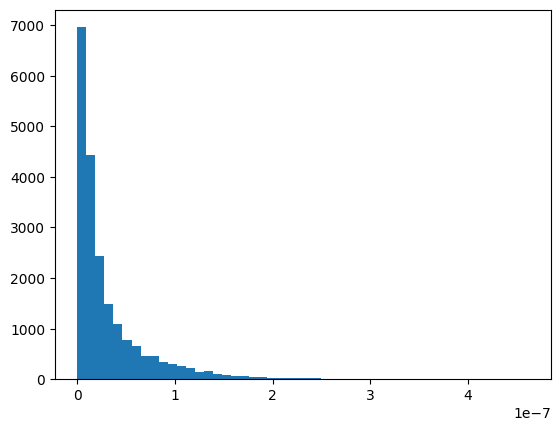

In [22]:
plt.hist(torch.abs(grads.to(device) -  derivative[:100]).detach().cpu().flatten(), bins=50)

In [18]:
import numpy as np
data = np.load('/home/mila/l/lena-nehale.ezzine/Amgen/DEM_fork/data/test_split_LJ13-1000.npy')

In [19]:
np.abs(data).max(), np.abs(data).min(), np.abs(data).mean(), np.abs(data).std()

(3.5050895, 4.6491623e-06, 0.5592112, 0.3879446)

(array([7.0000e+00, 6.0000e+00, 1.0000e+01, 2.1000e+01, 3.2000e+01,
        4.6000e+01, 7.4000e+01, 1.6100e+02, 3.0500e+02, 5.2400e+02,
        1.0470e+03, 2.0450e+03, 3.6190e+03, 6.2370e+03, 9.5120e+03,
        1.3156e+04, 1.6953e+04, 1.9372e+04, 2.1219e+04, 2.3010e+04,
        2.4631e+04, 2.5457e+04, 2.7066e+04, 2.6912e+04, 2.5750e+04,
        2.4668e+04, 2.3018e+04, 2.1360e+04, 1.9251e+04, 1.6675e+04,
        1.3370e+04, 9.6600e+03, 6.5460e+03, 3.7930e+03, 2.1200e+03,
        1.1280e+03, 5.5500e+02, 2.8900e+02, 1.5200e+02, 1.0200e+02,
        5.0000e+01, 3.5000e+01, 1.9000e+01, 1.5000e+01, 7.0000e+00,
        7.0000e+00, 2.0000e+00, 2.0000e+00, 2.0000e+00, 2.0000e+00]),
 array([-2.99143577e+00, -2.86150527e+00, -2.73157477e+00, -2.60164428e+00,
        -2.47171378e+00, -2.34178329e+00, -2.21185279e+00, -2.08192229e+00,
        -1.95199168e+00, -1.82206118e+00, -1.69213068e+00, -1.56220019e+00,
        -1.43226969e+00, -1.30233920e+00, -1.17240870e+00, -1.04247820e+00,
        -9.125

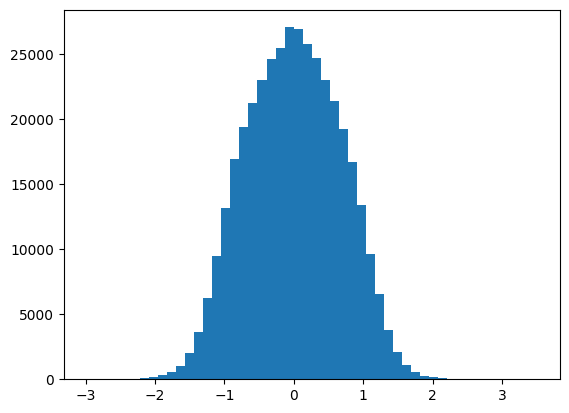

In [20]:
plt.hist(data.flatten(),bins = 50)

In [15]:
import numpy as np
data = np.load('/home/mila/l/lena-nehale.ezzine/Amgen/DEM_fork/data/TIfV_val.npy')

In [16]:
np.abs(data).max(), np.abs(data).min(), np.abs(data).mean(), np.abs(data).std()

(7.881, 0.0, 2.0349166, 1.5101234)

(array([1.100e+01, 4.200e+01, 9.200e+01, 3.700e+01, 1.630e+02, 2.270e+02,
        2.720e+02, 2.630e+02, 1.630e+02, 3.910e+02, 6.230e+02, 6.770e+02,
        7.960e+02, 8.510e+02, 6.070e+02, 9.440e+02, 1.520e+03, 1.537e+03,
        1.772e+03, 1.919e+03, 2.124e+03, 2.990e+03, 2.242e+03, 2.289e+03,
        2.474e+03, 3.027e+03, 2.630e+03, 2.791e+03, 2.598e+03, 2.016e+03,
        2.423e+03, 2.640e+03, 2.286e+03, 2.412e+03, 1.778e+03, 1.266e+03,
        1.278e+03, 1.025e+03, 9.450e+02, 1.034e+03, 6.110e+02, 6.820e+02,
        7.110e+02, 5.010e+02, 3.000e+02, 2.780e+02, 2.310e+02, 6.100e+01,
        2.800e+01, 3.000e+00]),
 array([-7.88100004, -7.58222008, -7.28344011, -6.98466015, -6.68588018,
        -6.38710022, -6.08832026, -5.78953981, -5.49075985, -5.19197989,
        -4.89319992, -4.59441996, -4.29563999, -3.99686003, -3.69808006,
        -3.3993001 , -3.1005199 , -2.80173993, -2.50295997, -2.20418   ,
        -1.90540004, -1.60661995, -1.30783999, -1.00906003, -0.71028   ,
        -0.

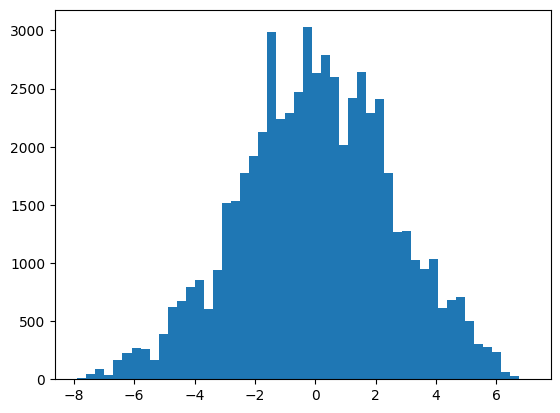

In [17]:
plt.hist(data.flatten(),bins = 50)

# GEOM-Drugs dataset exploration

In [1]:
#read json file
import json
with open('/home/mila/l/lena-nehale.ezzine/scratch/geomdrugs/rdkit_folder/summary_drugs.json') as json_file:

    summary_drugs = json.load(json_file)

In [2]:
import pickle
#load pickle file
with open('/home/mila/l/lena-nehale.ezzine/scratch/geomdrugs/rdkit_folder/drugs/CC12CCC(c3c(C(=O)O)nn(-c4ccc(F)cc4)c31)C2(C)C.pickle', 'rb') as f:
    drug = pickle.load(f) 

In [3]:
coords = []
for i in range(len(drug['conformers'])):
    x = drug['conformers'][i]['rd_mol'].GetConformer().GetPositions()
    coords.append(x)

In [4]:
import numpy as np
import periodictable

atoms = np.array([atom.GetSymbol() for atom in drug['conformers'][0]['rd_mol'].GetAtoms()])
atom_ids = [getattr(periodictable, symbol).number for symbol in atoms]

In [5]:
import numpy as np
import pickle
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
coords = torch.Tensor(coords).to(device).requires_grad_(True)
atom_ids = torch.Tensor(atom_ids).to(device).long().unsqueeze(0)

/tmp/ipykernel_2742661/1561331270.py:5: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:275.)
  coords = torch.Tensor(coords).to(device).requires_grad_(True)


(array([ 2.,  0.,  0.,  0.,  0.,  4.,  2.,  8., 12.,  8.,  6., 10., 22.,
        16.,  6., 22., 14., 38., 36., 18.,  6., 24., 28., 36., 56., 48.,
        38., 24., 32., 12., 34., 16., 36., 10., 20., 14., 22., 20.,  8.,
         6.,  6., 14., 10.,  0.,  8.,  0.,  0.,  0.,  0.,  4.]),
 array([-5.91295815, -5.67699671, -5.44103479, -5.20507336, -4.96911144,
        -4.73315001, -4.49718857, -4.26122665, -4.02526522, -3.78930354,
        -3.55334187, -3.31738019, -3.08141851, -2.84545708, -2.6094954 ,
        -2.37353373, -2.13757205, -1.90161049, -1.66564882, -1.42968726,
        -1.19372559, -0.95776397, -0.72180235, -0.48584071, -0.24987908,
        -0.01391745,  0.22204418,  0.45800582,  0.69396746,  0.92992908,
         1.16589069,  1.40185237,  1.63781393,  1.8737756 ,  2.10973716,
         2.34569883,  2.58166051,  2.81762218,  3.05358362,  3.2895453 ,
         3.52550697,  3.76146865,  3.99743032,  4.23339176,  4.46935368,
         4.70531511,  4.94127655,  5.17723846,  5.4131999 ,

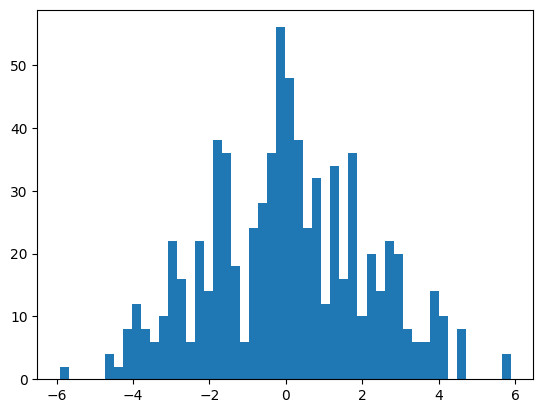

In [6]:
import matplotlib.pyplot as plt
plt.hist(coords.flatten().detach().cpu(), bins=50)

In [7]:
import torchani
model = torchani.models.ANI2x(periodic_table_index=True).to(device)

/home/mila/l/lena-nehale.ezzine/Amgen/DEM_fork/y/envs/dem/lib/python3.10/site-packages/torchani/aev.py:16: UserWarning: cuaev not installed
  warnings.warn("cuaev not installed")
/home/mila/l/lena-nehale.ezzine/Amgen/DEM_fork/y/envs/dem/lib/python3.10/site-packages/torchani/__init__.py:55: UserWarning: Dependency not satisfied, torchani.ase will not be available
  warnings.warn("Dependency not satisfied, torchani.ase will not be available")


/home/mila/l/lena-nehale.ezzine/Amgen/DEM_fork/y/envs/dem/lib/python3.10/site-packages/torchani/resources/


In [8]:
model((atom_ids.repeat(len(coords),1), coords)).energies

tensor([-1056.8765, -1056.8742, -1056.8765, -1056.8742, -1056.8631, -1056.8631],
       device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)

In [9]:
model((atom_ids.repeat(len(coords),1), 5*torch.rand_like(coords))).energies

tensor([-1047.4807, -1048.9402, -1046.9930, -1044.3501, -1048.8764, -1052.4616],
       device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)

In [10]:
coords.shape

torch.Size([6, 42, 3])